# TLS Demo with Point Cloud Scene

This demo uses a point cloud as scene, which is converted to a voxel model by HELIOS++ and scanned with terrestial laser scanning. We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.


In [1]:
import sys, os
from pathlib import Path
from IPython.display import Code

current_folder = globals()["_dh"][0]
helios_path = str(Path(current_folder).parent)
sys.path.append(helios_path)  # add helios-plusplus directory to PATH
import pyhelios

from pyhelios.util.xmldisplayer import display_xml, find_playback_dir
os.chdir(helios_path)

## Survey
Let us look at the XML files in the simulation. First, we investigate the survey XML file, `tls_sphere_xyzloader.xml`:

In [2]:
os.chdir(helios_path)
Code(display_xml(r'data\surveys\voxels\tls_sphere_xyzloader.xml'), language='XML')

<document>

    <survey name="tls_sphere_xyzloader" scene="data/scenes/voxels/sphere_xyzloader.xml#sphere_xyzloader_demo" platform="data/platforms.xml#tripod" scanner="data/scanners_tls.xml#riegl_vz400">
		<leg>
            <platformSettings x="40" y="-10" z="0" onGround="true" />
            <scannerSettings active="true" pulseFreq_hz="100000" verticalAngleMin_deg="-40.0" verticalAngleMax_deg="60.0" scanFreq_hz="120" headRotatePerSec_deg="10.00" headRotateStart_deg="250.0" headRotateStop_deg="380.0" />
        </leg>
    </survey>
</document>

We can see that there is one `leg` element corresponding to the scan position (SP) at `(40, -10)`. Furthermore, we can see that the `tripod` platform in `data\platforms.xml` is referenced, so let's look at that next.

## Platform


In [3]:
Code(display_xml(r'data\platforms.xml', 'tripod'))

<platform id="tripod" name="TLS Tripod" type="static" drag="0">
		<scannerMount x="0" y="0" z="1.5">
		</scannerMount>
		<!--<positionXNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.02"/>
		<positionYNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.02"/>
		<positionZNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.02"/>
		<attitudeXNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.001"/>
		<attitudeYNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.001"/>
		<attitudeZNoise
			clipMin="0.0" clipMax="0.0" clipEnabled="false" fixedLifespan="1"
			type="NORMAL" mean="0.0" stdev="0.001"/>-->
	</platform>

This is a very simple `static` type platform. Note the `scannerMount` parameter, indicating an elevation of `1.5` meters above the ground.

## Scanner
Now let's look at the scanner that is placed on this platform, the `riegl_vz400` defined in `data\scanners_tls.xml`:

In [4]:
Code(display_xml(r'data\scanners_tls.xml', 'riegl_vz400'))

<scanner id="riegl_vz400" name="RIEGL VZ-400" accuracy_m="0.005" beamDivergence_rad="0.0003" headRotatePerSecMax_deg="60" optics="rotating" pulseFreqs_Hz="100000,300000" pulseLength_ns="5" rangeMin_m="1.5" scanAngleMax_deg="120" scanAngleEffectiveMax_deg="50" scanFreqMin_Hz="3" scanFreqMax_Hz="120">
		
		<FWFSettings beamSampleQuality="3" />	
		<beamOrigin x="0" y="0" z="0.2">
			<rot axis="y" angle_deg="0" />
			<rot axis="z" angle_deg="0" />
			<rot axis="x" angle_deg="0" />
		</beamOrigin>
		<headRotateAxis x="0" y="0" z="1" />
		
	</scanner>

Here we see a lot of scanner-specific settings, including the minium range (`rangeMin_m`), the maximum scan angle (`scanAngleMax_deg`) that defines the polygonal mirror deflector, the resulting effective vertical field of view (`scanAngleEffectiveMax_deg`), and more. Additionally, we see the `beamOrigin` is set to `0.2` meters in `z`. Adding this to the platform offset, we arrive at a height of 1.7 meters above ground for the laser beam origin.

## Scene

Let's take a look at the scene, `sphere_xyzloader_demo` in `data\scenes\voxels\sphere_xyzloader.xml`:

In [5]:
Code(display_xml(r'data\scenes\voxels\sphere_xyzloader.xml', 'sphere_xyzloader_demo'))

<scene id="sphere_xyzloader_demo" name="sphere xyzloader demo">
        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/basic/groundplane/groundplane.obj" />
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="100" />
            </filter>
        </part>
        <part>
            <filter type="xyzloader">
                <param type="string" key="filepath" value="data/sceneparts/pointclouds/sphere_dens25000.xyz" />
				<param type="string" key="separator" value=" " />
				<param type="double" key="voxelSize" value="1.0" />
				<!-- Normal estimation using Singular Value Decomposition (SVD)
				MODE 1: simple mode / MODE 2: advanced mode for large files, which works in batches -->
				<param type="int" key="estimateNormals" value="1" />
				<!-- If less than three points fall into one voxel, it is discarded.
				To avoid this, a default Normal can be assigned to these voxels with:
				<param type="vec3" key="defaultNormal" value="0;0;1" /> -->
				<param type="string" key="matfile" value="data/sceneparts/toyblocks/sphere.mtl" />
				<param type="string" key="matname" value="Material.008" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="0;0;10" />
			</filter>
		</part>
    </scene>

This scene consits of a simple `groundplane.obj`, which is loaded with the `objloader` filter and a point cloud (`sphere_dens25000.xyz`) which is loaded with the `xyzloader` filter. HELIOS++ is transforming this point cloud into a voxel model which is then scanned. The size of the voxels is determined with the parameter `voxelSize` and the corresponding `value="1.0"`. 

## Executing the Simulation
Now, we are ready to run the simulation. In Jupyter Notebooks, we can run external commands with the `!command` syntax, but you can also just run it from the command line.

In [6]:
!"run/helios.exe" data\surveys\voxels\tls_sphere_xyzloader.xml
output_path = find_playback_dir(r"data\surveys\voxels\tls_sphere_xyzloader.xml")

HELIOS++ VERSION 1.1.1

CWD: "D:\helios"
seed: AUTO
surveyPath: "data\surveys\voxels\tls_sphere_xyzloader.xml"
assetsPath: "assets/"
outputPath: "output/"
writeWaveform: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 0
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 0
lasOutput: 0
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: tls_sphere_xyzloader.xml
xmlDocFilePath: data\surveys\voxels
xmlDocFilename: scanners_tls.xml
xmlDocFilePath: data
Using default value for attribute 'averagePower_w' : 4
Using default value for attribute 'beamQualityFactor' : 1
Using default value for attribute 'opticalEfficiency' : 0.99
Using default value for attribute 'receiverDiameter_m' : 0.15
Using default value for attribute 'atmosphericVisibility_km' : 23
Using default value for attribute 'wavelength_nm' : 1064
Scanner: riegl_vz400
Device[0]: riegl_vz400
	Aver

## The results

Now we can display a 3D plot of the result.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

print("Loading points from", Path(output_path).relative_to(helios_path).as_posix())

SP = np.loadtxt(Path(output_path) / 'leg000_points.xyz')


Loading points from output/tls_sphere_xyzloader/2023-02-08_11-20-14


In [8]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius]) 
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

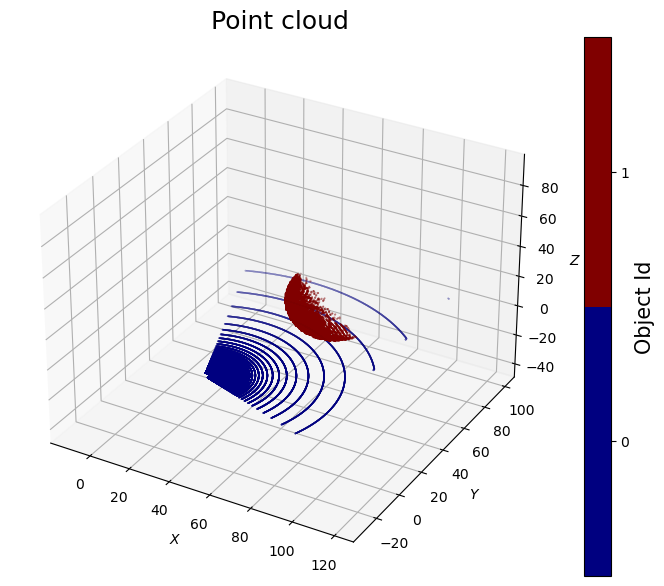

In [9]:
# Matplotlib figures.
fig = plt.figure(figsize=(9,7))


#settings for a discrete colorbar
N=2
cmap=plt.get_cmap('jet',N)

# Scatter plot of first scanner (coloured by hitObjectId).
ax = fig.add_subplot(projection='3d')
sc = ax.scatter(SP[:, 0], SP[:, 1], SP[:, 2], c= SP[:, 8], cmap=cmap, s=0.02, label='scene')

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

set_axes_equal(ax)    

# Set title.
ax.set_title(label='Point cloud',fontsize=18)

cbar = plt.colorbar(sc, ticks=[1/4, 3/4])

cbar.set_label("Object Id", fontsize=15)
cbar.ax.set_yticklabels(['0', '1'])

# Display results
plt.show()
